<a href="https://colab.research.google.com/github/Annie00000/Project/blob/main/1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.utils import to_categorical


## Load data

In [2]:
# 記錄開始時間
start_time = time.time()

# 讀取所有影像路徑和標籤
data_dir = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/train/'
image_paths = []
labels = []

for class_folder in os.listdir(data_dir):
    class_folder_path = os.path.join(data_dir, class_folder)
    for file in os.listdir(class_folder_path):
        fpath = os.path.join(class_folder_path, file)
        image_paths.append(fpath)
        labels.append(class_folder)

# 計算讀取時間
data_loading_time = time.time() - start_time
print(f"Data loading time: {data_loading_time} seconds")

Data loading time: 15.65560793876648 seconds


### 查看每个类别的比例

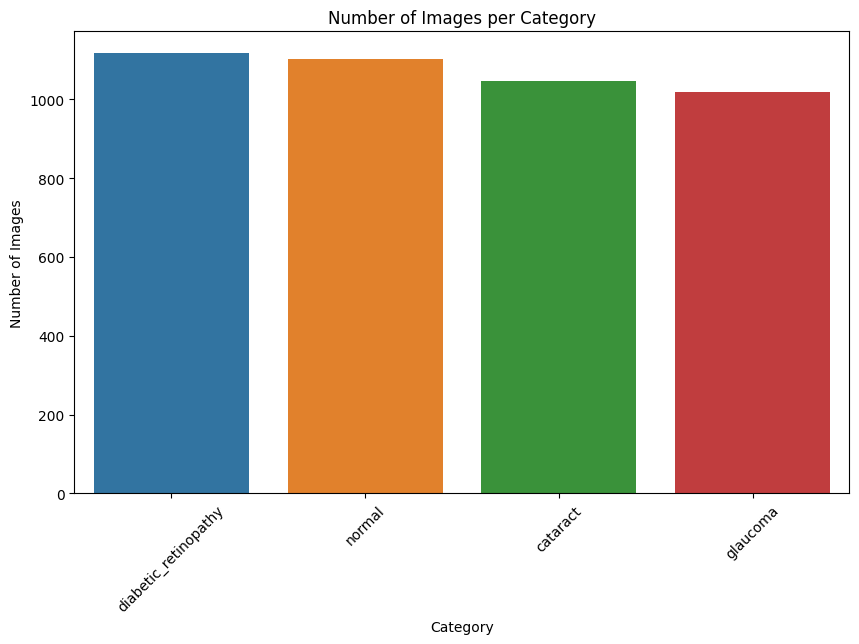

In [3]:
# 创建DataFrame
label_df = pd.DataFrame({'Label': labels, 'Image_Path': image_paths})

# 计算每个类别的图像数量
label_counts = label_df['Label'].value_counts()

# 可视化类别比例
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [4]:
# 文字表示每个类别的比例
for label, count in label_counts.items():
    print(f"Category '{label}':  {count} images, accounting for {round(100 * count/len(label_df),2)}% of all. ")

Category 'diabetic_retinopathy':  1117 images, accounting for 26.07% of all. 
Category 'normal':  1102 images, accounting for 25.72% of all. 
Category 'cataract':  1048 images, accounting for 24.46% of all. 
Category 'glaucoma':  1018 images, accounting for 23.76% of all. 


### 可视化每个类别各一张图片

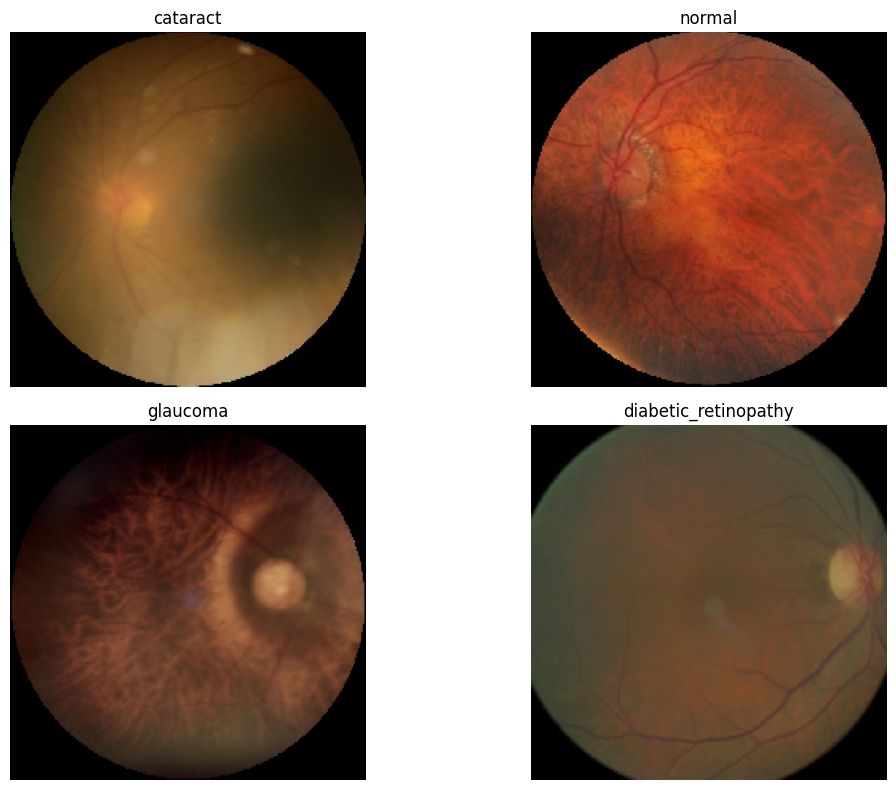

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 可视化每个类别的随机一张图片
unique_labels = label_df['Label'].unique()
plt.figure(figsize=(12, 8))

for i, label in enumerate(unique_labels):
    label_images = label_df[label_df['Label'] == label]['Image_Path'].tolist()
    random_image_path = random.choice(label_images)
    img = load_img(random_image_path, target_size=(224, 224))  # 调整为所需的尺寸

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 切分訓練集/驗證集/測試集

In [24]:
# 切分訓練集、驗證集和測試集
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels ,shuffle=True, random_state=42)
#val_paths, test_paths, val_labels, test_labels = train_test_split(test_val_paths, test_val_labels, test_size=0.5, stratify=test_val_labels,shuffle=True, random_state=42)

In [25]:
# 将标签转换为数字
unique_labels = sorted(set(labels))
label_to_index = {label: index for index, label in enumerate(unique_labels)}
#indices = [label_to_index[label] for label in labels]

# 建立標籤查詢的DataFrame
label_to_index_df = pd.DataFrame(list(label_to_index.items()), columns=['Label', 'Index'])

In [21]:
# 切分訓練集、驗證集和測試集
#train_paths, test_val_paths, train_indices, test_val_indices = train_test_split(image_paths, indices, test_size=0.3, shuffle=True, random_state=42)
#val_paths, test_paths, val_indices, test_indices = train_test_split(test_val_paths, test_val_indices, test_size=0.5, shuffle=True, random_state=42)

## Data augmentation (自定義數據增強)

In [9]:
# 載入CSV檔案來獲取增強設置
augmentation_csv_path = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/augmentation.csv'
augmentation_df = pd.read_csv(augmentation_csv_path)

# 創建一個字典來儲存每個類別的增強設置
augmentation_dict = {row['label']: row.drop('label').to_dict() for _, row in augmentation_df.iterrows()}
#augmentation_dict = {label_to_index[row['label']]: row.drop('label').to_dict() for _, row in augmentation_df.iterrows()}

In [26]:
augmentation_dict

{'normal': {'rotate 90': 0,
  'rotate 180': 0,
  'rotate 270': 0,
  '水平翻轉': 1,
  '垂直翻轉': 1},
 'glaucoma': {'rotate 90': 0,
  'rotate 180': 1,
  'rotate 270': 0,
  '水平翻轉': 1,
  '垂直翻轉': 0},
 'diabetic_retinopathy': {'rotate 90': 1,
  'rotate 180': 1,
  'rotate 270': 1,
  '水平翻轉': 0,
  '垂直翻轉': 0},
 'cataract': {'rotate 90': 1,
  'rotate 180': 1,
  'rotate 270': 1,
  '水平翻轉': 1,
  '垂直翻轉': 1}}

### 使用自定義數據生成器

In [27]:
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img)
            img = self.apply_augmentation(img, label) / 255.0
            batch_images.append(img)
            batch_labels.append(label)
            #batch_labels.append(self.label_to_index[label])  # Convert label to index

            # 將類別名稱轉成one hot 編碼
            batch_labels_one_hot = to_categorical([self.label_to_index[label] for label in batch_labels], num_classes=self.num_classes)
            #to_categorical(batch_labels, num_classes=self.num_classes)

        return np.array(batch_images), batch_labels_one_hot

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = np.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = np.rot90(image, k=2)

        # 翻转
        if random.choice([True, False]) and settings.get('水平翻轉'):
            image = np.fliplr(image)
        if random.choice([True, False]) and settings.get('垂直翻轉'):
            image = np.flipud(image)

        return image

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

#### (補) 增加 oversampling

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, oversample=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.oversample = oversample
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img)
            img = self.apply_augmentation(img, label)  # 应用数据增强
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return np.array(batch_images) / 255.0, to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = np.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = np.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = np.fliplr(image) if random.choice([True, False]) else image
        if settings.get('垂直翻轉'):
            image = np.flipud(image) if random.choice([True, False]) else image

        return image

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.oversample:
            self.image_paths, self.labels = self.__oversample_data()
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __oversample_data(self):
        max_size = max([sum(self.labels == label) for label in np.unique(self.labels)])
        new_image_paths = []
        new_labels = []
        for label in np.unique(self.labels):
            label_indices = np.where(self.labels == label)[0]
            upsample_indices = np.random.choice(label_indices, size=max_size, replace=True)
            new_image_paths.extend(self.image_paths[upsample_indices])
            new_labels.extend(self.labels[upsample_indices])
        return np.array(new_image_paths), np.array(new_labels)

#### (補) 使用GPU 的方式來執行數據增強，加快速度 (沒有oversampling)

In [ ]:
class CustomDataGenerator(Sequence):
    # ...（其他方法不变）

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]

            # 加载和预处理图像
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, self.target_size)

            # 应用数据增强
            img = self.apply_augmentation(img, label)
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    # apply_augmentation 方法不变

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]

            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, self.target_size)

            img = self.apply_augmentation(img, label)
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# 创建数据生成器实例
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), shuffle=False
)

# 创建模型
model = Sequential([
    DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    Flatten(),
    Dense(len(unique_labels), activation='softmax')
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min')
]

# 训练模型
history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks)

#### (補) 使用GPU 的方式來執行數據增強，加快速度 (有oversampling)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
import random

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, oversample=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.oversample = oversample
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]

            # 加载和预处理图像
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, self.target_size)

            # 应用数据增强
            img = self.apply_augmentation(img, label)
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.oversample:
            self.image_paths, self.labels = self.__oversample_data()
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __oversample_data(self):
        max_size = max([sum(self.labels == label) for label in np.unique(self.labels)])
        new_image_paths = []
        new_labels = []
        for label in np.unique(self.labels):
            label_indices = np.where(self.labels == label)[0]
            upsample_indices = np.random.choice(label_indices, size=max_size, replace=True)
            new_image_paths.extend(self.image_paths[upsample_indices])
            new_labels.extend(self.labels[upsample_indices])
        return np.array(new_image_paths), np.array(new_labels)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 假设您已经定义了下面的变量
# train_paths, train_labels, val_paths, val_labels, augmentation_dict, label_to_index, unique_labels

# 创建数据生成器实例
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=True, shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=False, shuffle=False
)


### 创建数据生成器实例

In [28]:
# 假设 label_to_index 和 num_classes 已经定义
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224), augmentation_dict=augmentation_dict,
    label_to_index=label_to_index, num_classes=len(unique_labels), shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224), augmentation_dict={},
    label_to_index=label_to_index, num_classes=len(unique_labels), shuffle=False
)

In [ ]:
# 创建数据生成器实例
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=True, shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=False, shuffle=False
)



## Model

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback

# 創建DenseNet模型
model = Sequential([
    DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    Flatten(),
    Dense(len(unique_labels), activation='softmax')
])

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 設定回調
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min') # 可改成.keras格式('model_best.keras')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)


callbacks = [early_stopping, model_checkpoint]# , reduce_lr

In [30]:
# 開始訓練
training_start_time = time.time()

# 訓練
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

'''
## 可以考慮 調整類別權重來 改善 資料不平衡
from sklearn.utils.class_weight import compute_class_weight

# 计算类别权重
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_labels), class_weights)}

# 在模型训练时使用类别权重
history = model.fit(train_generator, validation_data=val_generator, epochs=10, class_weight=class_weights)
'''

training_duration = time.time() - training_start_time
print(f"Total training time: {training_duration} seconds")

Epoch 1/10
108/108 [==============================] - 3267s 30s/step - loss: 4.5263 - accuracy: 0.5370 - val_loss: 131.4799 - val_accuracy: 0.2567
Epoch 2/10
108/108 [==============================] - 58s 533ms/step - loss: 3.9705 - accuracy: 0.4980 - val_loss: 6.6973 - val_accuracy: 0.2579
Epoch 3/10
108/108 [==============================] - 60s 558ms/step - loss: 2.9160 - accuracy: 0.4837 - val_loss: 1130.9878 - val_accuracy: 0.3081
Epoch 4/10
108/108 [==============================] - 54s 502ms/step - loss: 2.4733 - accuracy: 0.5610 - val_loss: 1.6758 - val_accuracy: 0.4236
Epoch 5/10
108/108 [==============================] - 59s 542ms/step - loss: 1.9329 - accuracy: 0.5814 - val_loss: 2.4290 - val_accuracy: 0.4842
Epoch 6/10
108/108 [==============================] - 54s 496ms/step - loss: 1.7641 - accuracy: 0.6068 - val_loss: 2.3804 - val_accuracy: 0.3944
Epoch 7/10
108/108 [==============================] - 54s 497ms/step - loss: 1.1578 - accuracy: 0.6727 - val_loss: 0.9563 - v

### 查看訓練結果

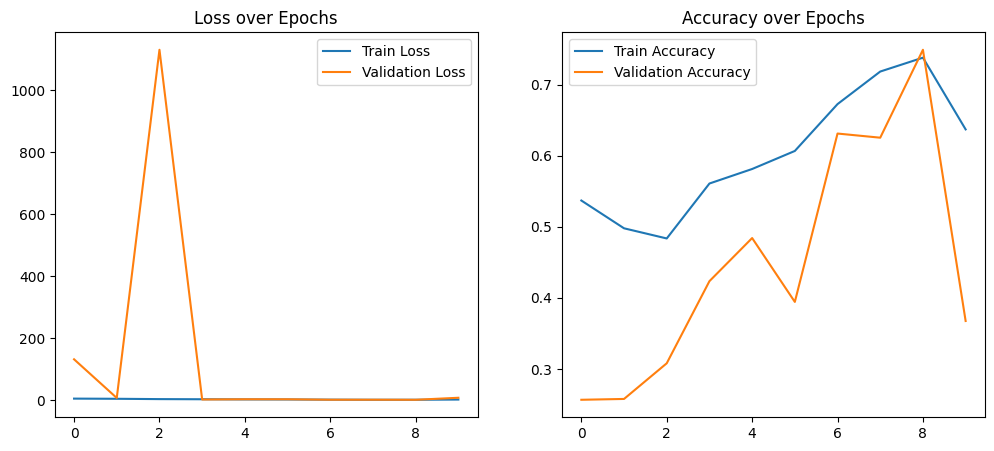

In [31]:
# 绘制训练和验证过程中的损失和准确率
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

#### Tensor版

在下面這个生成器中，我们首先将每个图像加载为 NumPy 数组，然后使用 tf.convert_to_tensor 将其转换为 TensorFlow Tensor。之后，我们将这个 Tensor 传递给 apply_augmentation 函数进行增强。最后，我们将整个批次的图像和标签列表转换为 TensorFlow Tensor，以便与 TensorFlow 模型兼容。

请注意，这种方法将在内存中保留整个批次的图像数据，所以如果您处理的图像数据量非常大，可能需要调整批次大小以避免内存不足的问题。此外，由于 apply_augmentation 现在接受的是 Tensor，确保所有的图像处理操作都是在 TensorFlow 的图操作中完成的。

In [ ]:

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img)
            img = tf.convert_to_tensor(img)  # 将图像转换为Tensor
            img = self.apply_augmentation(img, label, self.augmentation_dict)
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])  # Convert label to index

        # 转换为TensorFlow Tensor格式
        batch_images = tf.convert_to_tensor(batch_images)
        batch_labels = tf.convert_to_tensor(batch_labels)

        return batch_images, to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(image, label, augmentation_dict):
        settings = augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if  settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image


    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)



##### Tensor + 數據增強 + 不平衡數據集處理(oversampling)

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, oversample=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.oversample = oversample
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img)
            img = tf.convert_to_tensor(img)  # 将图像转换为Tensor
            img = self.apply_augmentation(img, label, self.augmentation_dict)  # 使用 TensorFlow 图像操作
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image


    def on_epoch_end(self):
        if self.oversample:
            max_size = max([sum(self.labels == label) for label in np.unique(self.labels)])
            self.image_paths, self.labels = self.__oversample_data(max_size)

        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __oversample_data(self, max_size):
        new_image_paths = []
        new_labels = []
        for label in np.unique(self.labels):
            label_indices = np.where(self.labels == label)[0]
            upsample_indices = np.random.choice(label_indices, size=max_size, replace=True)
            new_image_paths.extend(self.image_paths[upsample_indices])
            new_labels.extend(self.labels[upsample_indices])
        return np.array(new_image_paths), np.array(new_labels)



In [ ]:
# 创建模型
model = Sequential([
    DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    Flatten(),
    Dense(len(unique_labels), activation='softmax')
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min')
]

# 训练模型，使用过采样和数据增强
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=True, shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=False, shuffle=False
)

history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

## 測試集檢驗

In [ ]:
# 定义测试数据的路径
test_data_dir = '/path/to/your/test/data/'

# 读取所有测试图像的路径和标签
test_image_paths = []
test_labels = []

for class_folder in os.listdir(test_data_dir):
    class_folder_path = os.path.join(test_data_dir, class_folder)
    for file in os.listdir(class_folder_path):
        fpath = os.path.join(class_folder_path, file)
        test_image_paths.append(fpath)
        test_labels.append(class_folder)

# 创建测试集的数据生成器
test_generator = CustomDataGenerator(
    test_image_paths, test_labels, batch_size=32, target_size=(224, 224), augmentation_dict={},
    label_to_index=label_to_index, num_classes=len(unique_labels), shuffle=False)

In [ ]:
# 开始计时
test_start_time = time.time()

# 对测试集进行评估
test_loss, test_accuracy = model.evaluate(test_generator)

# 记录运行时间
test_duration = time.time() - test_start_time
print(f"Test Evaluation Time: {test_duration} seconds")

# 打印结果
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

### 繪製confusion table

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 获取测试集上的预测结果
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 将测试集的真实标签转换为索引
true_classes = np.array([label_to_index[label] for label in test_labels])

# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 如果測試集資料很大

如果测试集很大，导致一次性使用 model.predict 函数时内存不足，您可以通过逐批处理测试集数据并"分批"收集预测结果来解决这个问题。以下是分批预测并计算混淆矩阵的步骤：


1. 初始化：创建两个空列表，一个用于存储预测类别，另一个用于存储真实类别。
2. 逐批预测：遍历测试数据生成器的每一个批次，使用模型进行预测，并将预测结果与真实标签存储起来。

In [ ]:
total_loss = 0.0
total_accuracy = 0.0
num_batches = 0

for batch_images, batch_labels in test_generator:
    loss, accuracy = model.evaluate(batch_images, batch_labels, verbose=0)
    total_loss += loss
    total_accuracy += accuracy
    num_batches += 1

# 计算平均损失值和准确率
average_loss = total_loss / num_batches
average_accuracy = total_accuracy / num_batches

print(f"Test Loss: {average_loss}")
print(f"Test Accuracy: {average_accuracy}")

In [ ]:
predicted_classes = []
true_classes = []

for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    batch_predictions = model.predict(batch_images)
    batch_predicted_classes = np.argmax(batch_predictions, axis=1)

    predicted_classes.extend(batch_predicted_classes)
    true_classes.extend(np.argmax(batch_labels, axis=1))

# 确保预测结果和真实标签是 NumPy 数组
predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)

In [ ]:
# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

注意事项 :

确保在遍历生成器时不要改变其状态（例如，不要重新洗牌）。

如果您的模型在编译时设置了 metrics=['accuracy']，则还可以在每个批次中计算精度，并最后平均这些精度值以获得整体精度。

### 查看分錯的類別&其正確標籤

In [ ]:
'''
# 获取预测结果
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 将真实标签转换为索引
true_classes = np.array([label_to_index[label] for label in test_labels])
'''

# 找出预测错误的案例
incorrect_indices = np.where(predicted_classes != true_classes)[0]

# 选择要展示的错误案例数量
num_samples_to_show = 5
if len(incorrect_indices) > num_samples_to_show:
    incorrect_indices = np.random.choice(incorrect_indices, num_samples_to_show, replace=False)
# sample_idxs = np.random.choice(misclassified_idxs, num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(incorrect_indices):
    img_path = test_image_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {index_to_label[predicted_classes[index]]}\nTrue: {index_to_label[true_classes[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### 查看特定類別中，被错误分类的案例

In [ ]:
# 定義要查看的類別
specific_label = 'cat'
specific_label_index = label_to_index[specific_label]

'''
# 获取预测结果
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 将真实标签转换为索引
true_classes = np.array([label_to_index[label] for label in test_labels])
'''

# 找出特定类别中 被错误分类的案例
incorrect_indices = np.where((predicted_classes != true_classes) & (true_classes == specific_label_index))[0]

# 选择要展示的错误案例数量
num_samples_to_show = 5
if len(incorrect_indices) > num_samples_to_show:
    incorrect_indices = np.random.choice(incorrect_indices, num_samples_to_show, replace=False)

# 可视化错误分类的图片
plt.figure(figsize=(15, 5))
for i, index in enumerate(incorrect_indices):
    img_path = test_image_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {index_to_label[predicted_classes[index]]}\nTrue: {specific_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

'''
### 全展示
plt.figure(figsize=(15, len(incorrect_indices) * 3))
for i, index in enumerate(incorrect_indices):
    img_path = test_image_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(len(incorrect_indices), 1, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {index_to_label[predicted_classes[index]]}\nTrue: {specific_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
'''

### 查看被錯誤分類類別中，其被错误分类的案例

In [ ]:
# 定义被错误分类为的特定类别
misclassified_as_label = 'fish'  # 您关注的被错误分类为的类别
misclassified_as_index = label_to_index[misclassified_as_label]

# 找出被错误分类为特定类别的案例
incorrectly_classified_as_indices = np.where((predicted_classes == misclassified_as_index) & (true_classes != misclassified_as_index))[0]

#
plt.figure(figsize=(15, len(incorrectly_classified_as_indices) * 3))
for i, index in enumerate(incorrectly_classified_as_indices):
    img_path = test_image_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(len(incorrectly_classified_as_indices), 1, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {misclassified_as_label}\nTrue: {index_to_label[true_classes[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()